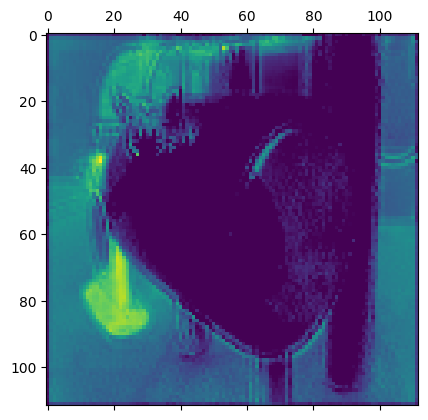

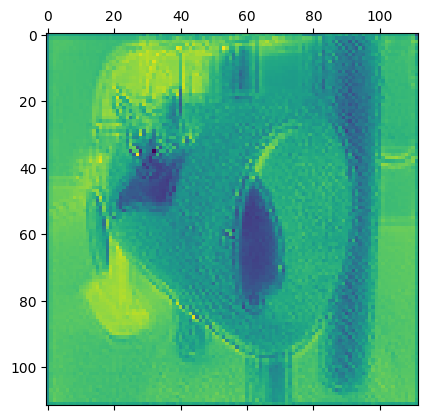

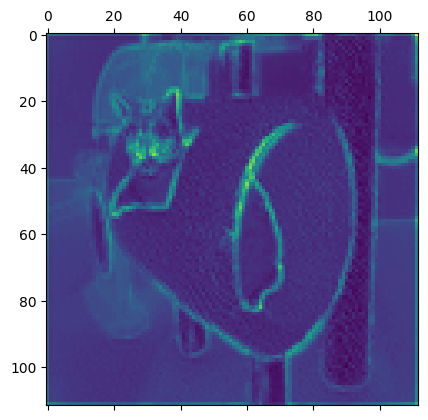

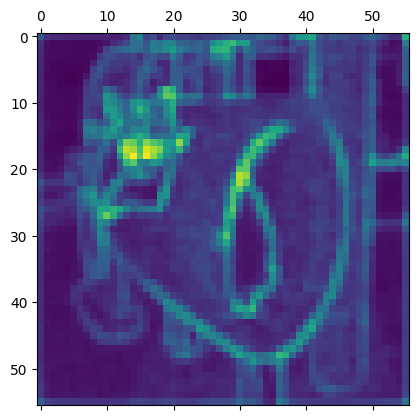

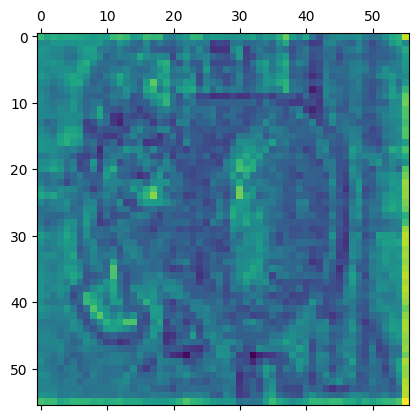

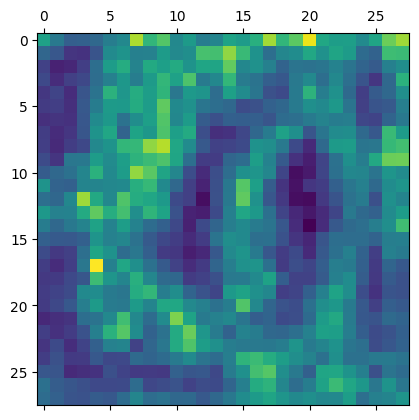

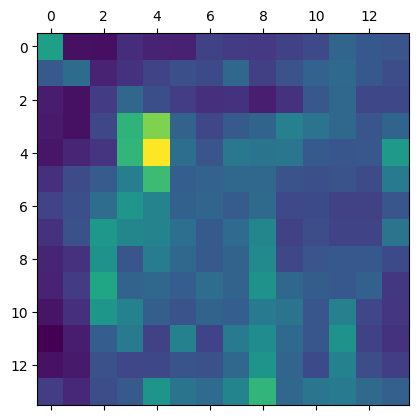

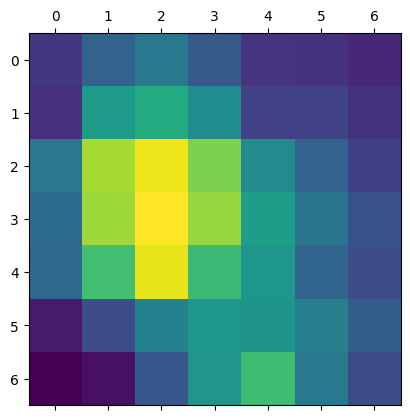

In [34]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# ResNet Class
class ResNetLayerVisualizer(nn.Module):
    def __init__(self, layer_index):
        super(ResNetLayerVisualizer, self).__init__()

        # Load the pre-trained ResNet50 model
        self.resnet = resnet50(pretrained=True)

        # Extract layers up to the specified index
        self.features = nn.Sequential(*list(self.resnet.children())[:layer_index + 1])

        # gradient placeholder
        self.gradient = None

    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad

    def get_gradient(self):
        return self.gradient

    def get_activations(self, x):
        return self.features(x)

    def forward(self, x):
        # extract the features
        x = self.features(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # reduce the output to a scalar value for gradient computation
        x = x.mean()

        return x

# Load an example image
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
image_path = 'data/train/cat/cat.90.jpg'
input_image = transform(Image.open(image_path)).unsqueeze(0)

# Visualize each layer separately
for layer_idx in range(8):  # Change the range based on the number of layers you want to visualize
    # Initialize the ResNet model for the specific layer
    resnet_layer_model = ResNetLayerVisualizer(layer_index=layer_idx)

    # Set the evaluation mode
    _ = resnet_layer_model.eval()

    # Reset gradient
    resnet_layer_model.gradient = None

    # Forward pass to compute gradients
    pred = resnet_layer_model(input_image)
    pred.backward(retain_graph=True)

    # Get the gradients
    gradients = resnet_layer_model.get_gradient()

    # Pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Get the activations of the layer
    activations = resnet_layer_model.get_activations(input_image).detach()

    # Weight the channels by corresponding gradients
    for i in range(activations.size(1)):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # ReLU on top of the heatmap
    heatmap = np.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= torch.max(heatmap)

    # # Display the heatmap
    # print(heatmap.shape)
    # plt.imshow(heatmap.cpu().numpy(), cmap='hot')
    # plt.title(f"Heatmap for Layer {layer_idx + 1}")
    # plt.colorbar()
    # plt.show()
    # draw the heatmap
    plt.matshow(heatmap.cpu().numpy())

    # make the heatmap to be a numpy array
    heatmap = heatmap.cpu().numpy()

    # interpolate the heatmap
    img = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite(f'results/layer{layer_idx}.jpg', superimposed_img)



torch.Size([112, 112])


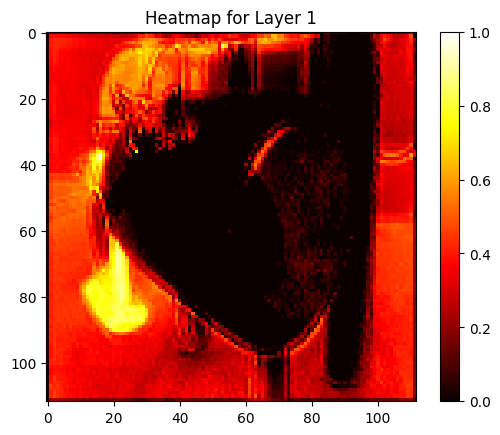

torch.Size([112, 112])


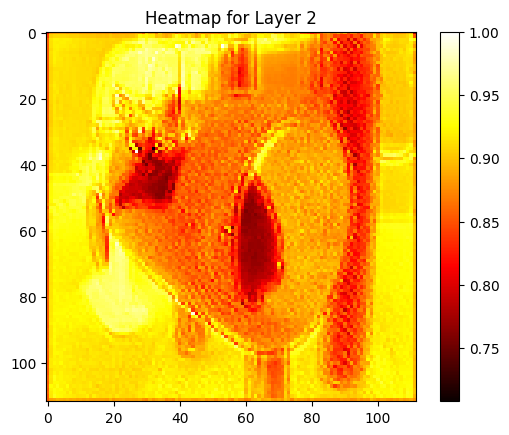

torch.Size([112, 112])


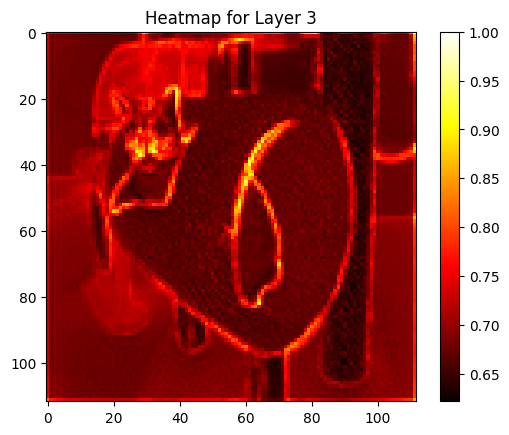

torch.Size([56, 56])


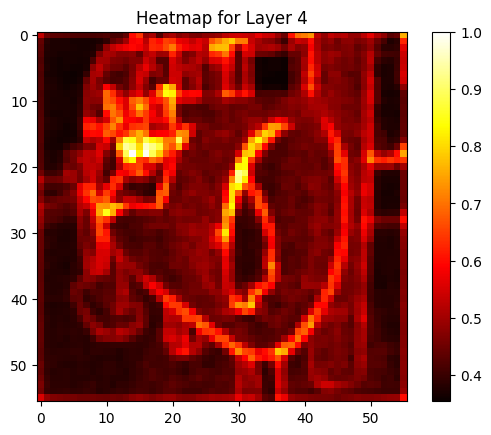

torch.Size([56, 56])


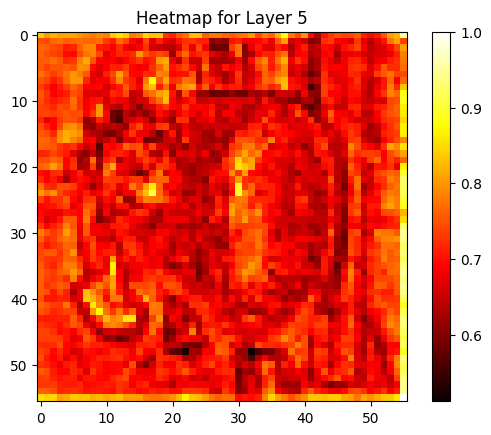

torch.Size([28, 28])


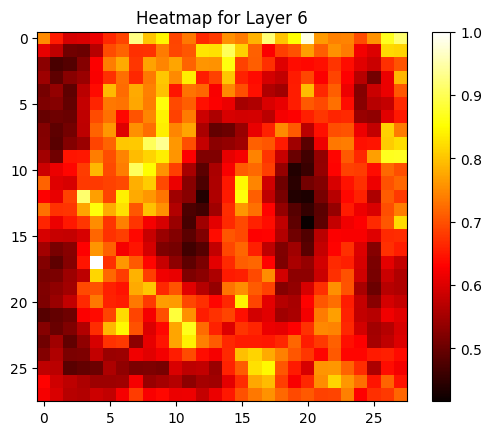

torch.Size([14, 14])


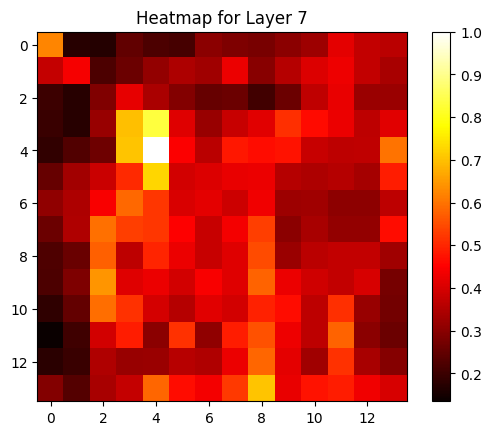

torch.Size([7, 7])


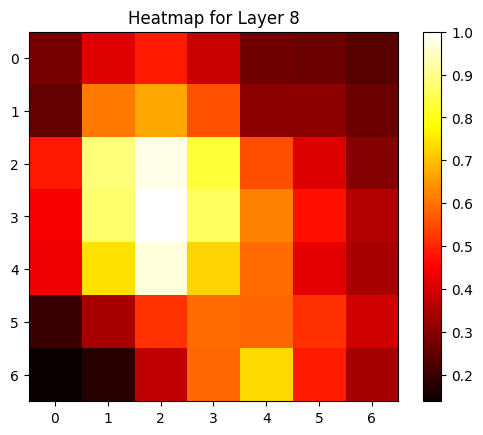

In [35]:
# Load an example image
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
image_path = 'data/train/cat/cat.90.jpg'
input_image = transform(Image.open(image_path)).unsqueeze(0)

# Visualize each layer separately
for layer_idx in range(8):  # Change the range based on the number of layers you want to visualize
    # Initialize the ResNet model for the specific layer
    resnet_layer_model = ResNetLayerVisualizer(layer_index=layer_idx)

    # Set the evaluation mode
    _ = resnet_layer_model.eval()

    # Reset gradient
    resnet_layer_model.gradient = None

    # Forward pass to compute gradients
    pred = resnet_layer_model(input_image)
    pred.backward(retain_graph=True)

    # Get the gradients
    gradients = resnet_layer_model.get_gradient()

    # Pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Get the activations of the layer
    activations = resnet_layer_model.get_activations(input_image).detach()

    # Weight the channels by corresponding gradients
    for i in range(activations.size(1)):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # ReLU on top of the heatmap
    heatmap = np.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= torch.max(heatmap)

    # # Display the heatmap
    print(heatmap.shape)
    plt.imshow(heatmap.cpu().numpy(), cmap='hot')
    plt.title(f"Heatmap for Layer {layer_idx + 1}")
    plt.colorbar()
    plt.show()